<a href="https://colab.research.google.com/github/ThuyHaLE/Image_processing/blob/main/Low_rank_approximation_using_SVD_(Singular_value_decomposition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files

#Low-rank approximation

##Functions

In [ ]:
#ConvertColorToGrayScale(3 chanels => 1 chanel)
#OpenCV uses BGR image format blue[0], green[1], red[2]
def convertColorToGrayScale(image):
  ratio = [0.0722, 0.7152, 0.2126] #red(0.2126), green (0.7152), and blue (0.0722) => grayscale
  grayscale = np.zeros(image.shape)
  for i in range(len(ratio)):
    grayscale[:,:,i] = image[:,:,i]*ratio[i]
  img_gray = grayscale.sum(axis=-1)
  return np.around(img_gray)

In [ ]:
#evaluate SVD for feature compression by metric (cosine_similarity or root_mean_square_error)
def evaluate_svd_for_feature_compression_by_metric(gray_image, metric='cosine'):
  U,D,V_T = np.linalg.svd(gray_image,full_matrices=False)
  rank_k = len(D)
  D = np.diag(D)
  approx_list = []
  metric_list = []
  for i in range(1,rank_k+1,1):
    approx = None
    approx = U[:,:i]@D[:i,:i]@V_T[:i,:]
    approx_list.append(approx)
    if metric == 'cosine':
      cosine = compute_cosine_similarity(gray_image, approx)
      metric_list.append(cosine)
    elif metric == 'rmse':
      rmse = compute_rms_error(gray_image, approx)
      metric_list.append(rmse)
  return metric_list, approx_list, rank_k

In [ ]:
#Compute cosine similarity for two matrices (images)
def compute_cosine_similarity(matrix1, matrix2):
  matrix1 = matrix1.flatten()
  matrix2 = matrix2.flatten()
  result = (matrix1@matrix2)/(np.linalg.norm(matrix1)*np.linalg.norm(matrix2))
  return result

In [ ]:
#compute Root Mean Square Error for two matrices (images)
def compute_rms_error(matrix1, matrix2):
  matrix1 = matrix1.flatten()
  matrix2 = matrix2.flatten()
  result = np.sqrt((1/len(matrix1))*sum((matrix2 - matrix1)*(matrix2 - matrix1)))
  return result

In [ ]:
#Plot metric information by rank k
def draw_metric_information(metric_list, k, metric):
  if metric == 'cosine':
    x_axis = list(range(1,k+1,1))
    plt.xlabel("k")
    plt.ylabel("Cosine similarity")
    plt.plot(x_axis,metric_list, color="b")
    plt.show()
  elif metric == 'rmse':
    x_axis = list(range(1,k+1,1))
    plt.xlabel("k")
    plt.ylabel("RMS error")
    plt.plot(x_axis,metric_list, color="r")
    plt.show()

#Plot image by rank k
def draw_approx_image(approx_list, k):
  step = 20
  col = 10
  row = k//step//col+1
  fig = plt.figure(figsize=(25, 25))
  fig_index = 1
  for i in range(0, k, step):
    fig.add_subplot(row, col, fig_index)
    plt.imshow(approx_list[i], cmap="gray")
    plt.axis('off')
    plt.title("k =" + str(i+1))
    fig_index = fig_index + 1
  plt.show()

In [ ]:
def main_application(image, metric):
  metric_list, approx_list, k =  evaluate_svd_for_feature_compression_by_metric(image, metric)
  draw_metric_information(metric_list, k, metric)
  draw_approx_image(approx_list, k)

##Results

In [ ]:
uploaded = files.upload()

Saving cat.jpeg to cat.jpeg


In [ ]:
image = cv2.imread('/content/cat.jpeg') #/content/your_file_name
print(image.shape)
image = cv2.resize(image, (1000,1000))
print(image.shape)
gray_image = convertColorToGrayScale(image)
cv2_imshow(gray_image)

(1280, 1225, 3)
(1000, 1000, 3)


###Cosine similarity

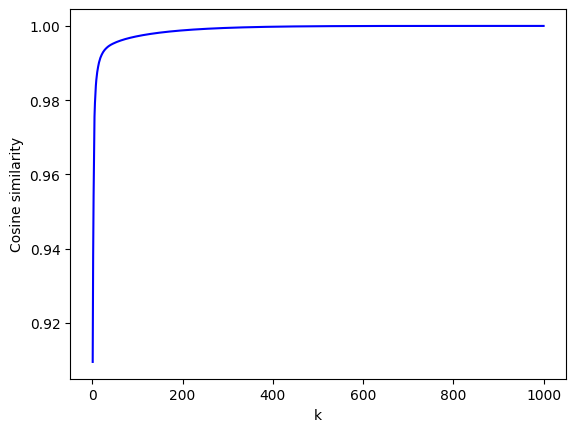

In [ ]:
main_application(gray_image, metric='cosine')

###RMSE

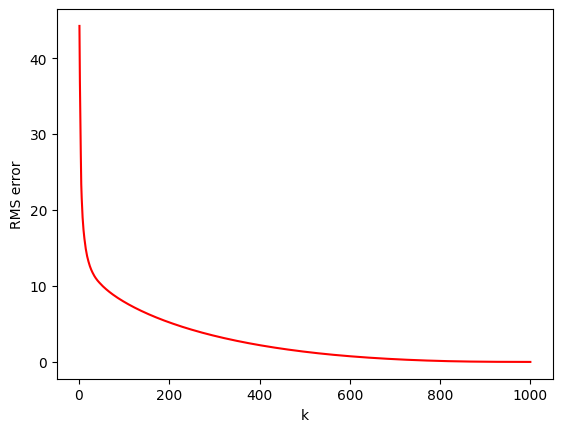

In [ ]:
main_application(gray_image, metric='rmse')

#Find best k

##Function

In [ ]:
#find best k by metric (cosine_similarity or root_mean_square_error)
def find_best_k_by_metric(gray_image, metric='cosine', alpha=1e-3): #alpha: difference from metric_result and best_metric_result
  U,D,V_T = np.linalg.svd(gray_image,full_matrices=False)
  rank_k = len(D)
  for i in range(1,rank_k+1,1):
    approx = np.array(np.dot(U[:, :i] * D[:i], V_T[:i,:]))
    if metric == 'cosine':
      cosine = compute_cosine_similarity(gray_image, approx)
      if 1 - cosine < alpha:
        best_metric = cosine
        best_k = i
        best_U, best_D, best_V_T = U[:, :i], D[:i], V_T[:i,:]
        break
    elif metric == 'rmse':
      rmse = compute_rms_error(gray_image, approx)
      if rmse < alpha:
        best_metric = rmse
        best_k = i
        best_U, best_D, best_V_T = U[:, :i], D[:i], V_T[:i,:]
        break
  return rank_k, best_k, best_metric, best_U, best_D, best_V_T

##Results

###Cosine similarity

In [ ]:
rank_k, best_k, best_metric, best_U, best_D, best_V_T = find_best_k_by_metric(gray_image, metric='cosine', alpha=1e-3)

In [ ]:
print(f'rank_k: {rank_k}, \nbest_k: {best_k}, \ncosine_similarity: {best_metric}')

rank_k: 1000, 
best_k: 222, 
cosine_similarity: 0.9990005082164007


In [ ]:
#The space (percent) was reduced by using SVD (with rank k = r)
reduced_space = round(100*(gray_image.size - (best_U.size + best_D.size + best_V_T.size))/gray_image.size)
print(f'r: {best_k}, full rank: {rank_k}')
print(f'size_of_gray_image: {gray_image.shape}, type: {gray_image.dtype}')
print(f'size_and_type_of_3_components (rank k = r): {best_U.shape}.{best_U.dtype} + {best_D.shape}.{best_D.dtype} + {best_V_T.shape}.{best_V_T.dtype}')
print(f'The space (percent) was reduced by using SVD (with rank k = r): {reduced_space}')

r: 222, full rank: 1000
size_of_gray_image: (1000, 1000), type: float64
size_and_type_of_3_components (rank k = r): (1000, 222).float64 + (222,).float64 + (222, 1000).float64
The space (percent) was reduced by using SVD (with rank k = r): 55.5778


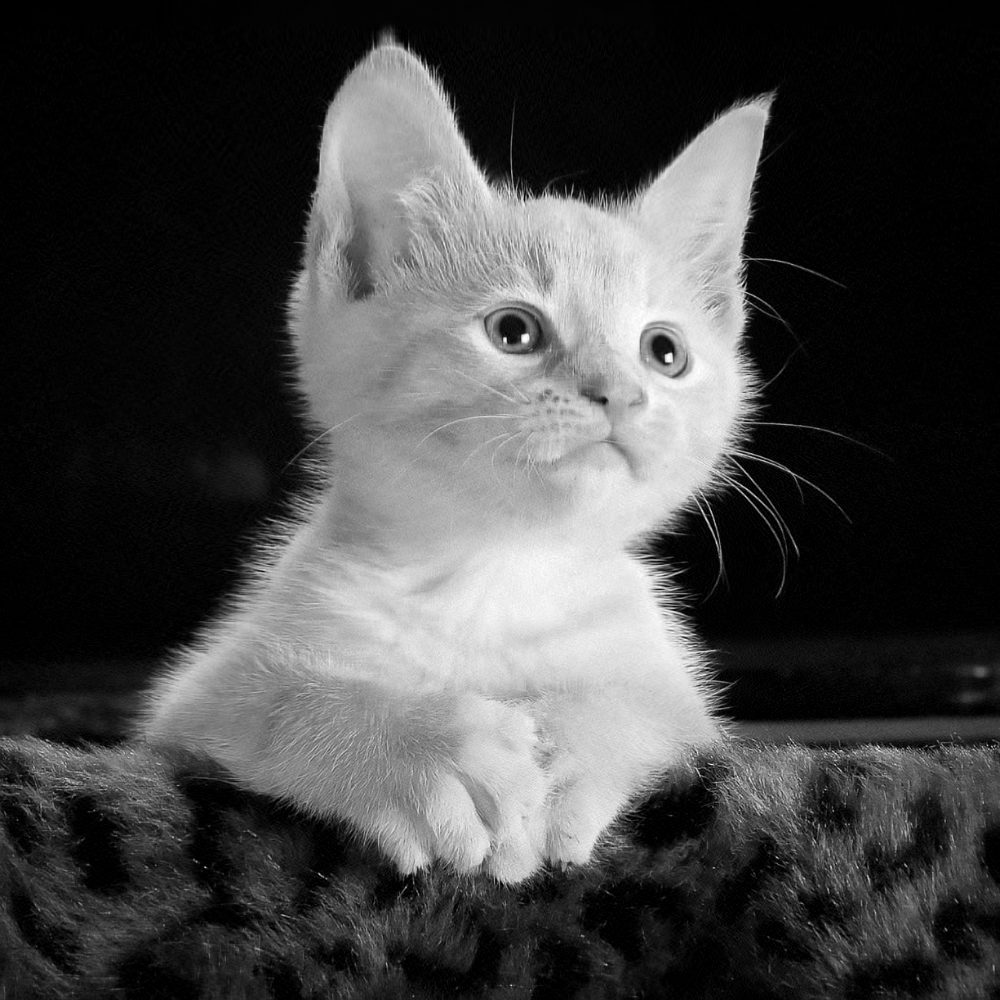

In [ ]:
cv2_imshow(np.array( np.dot(best_U*best_D, best_V_T)))

###RMSE

In [ ]:
rank_k, best_k, best_metric, best_U, best_D, best_V_T = find_best_k_by_metric(gray_image, metric='rmse', alpha=1e-1)

In [ ]:
print(f'rank_k: {rank_k}, \nbest_k: {best_k}, \ncosine_similarity: {best_metric}')

rank_k: 1000, 
best_k: 819, 
cosine_similarity: 0.09938971862093512


In [ ]:
#The space (percent) was reduced by using SVD (with rank k = r)
reduced_space = 100*(gray_image.size - (best_U.size + best_D.size + best_V_T.size))/gray_image.size
print(f'r: {best_k}, full rank: {rank_k}')
print(f'size_of_gray_image: {gray_image.shape}, type: {gray_image.dtype}')
print(f'size_and_type_of_3_components (rank k = r): {best_U.shape}.{best_U.dtype} + {best_D.shape}.{best_D.dtype} + {best_V_T.shape}.{best_V_T.dtype}')
print(f'The space (percent) was reduced by using SVD (with rank k = r): {reduced_space}')

r: 819, full rank: 1000
size_of_gray_image: (1000, 1000), type: float64
size_and_type_of_3_components (rank k = r): (1000, 819).float64 + (819,).float64 + (819, 1000).float64
The space (percent) was reduced by using SVD (with rank k = r): -63.8819


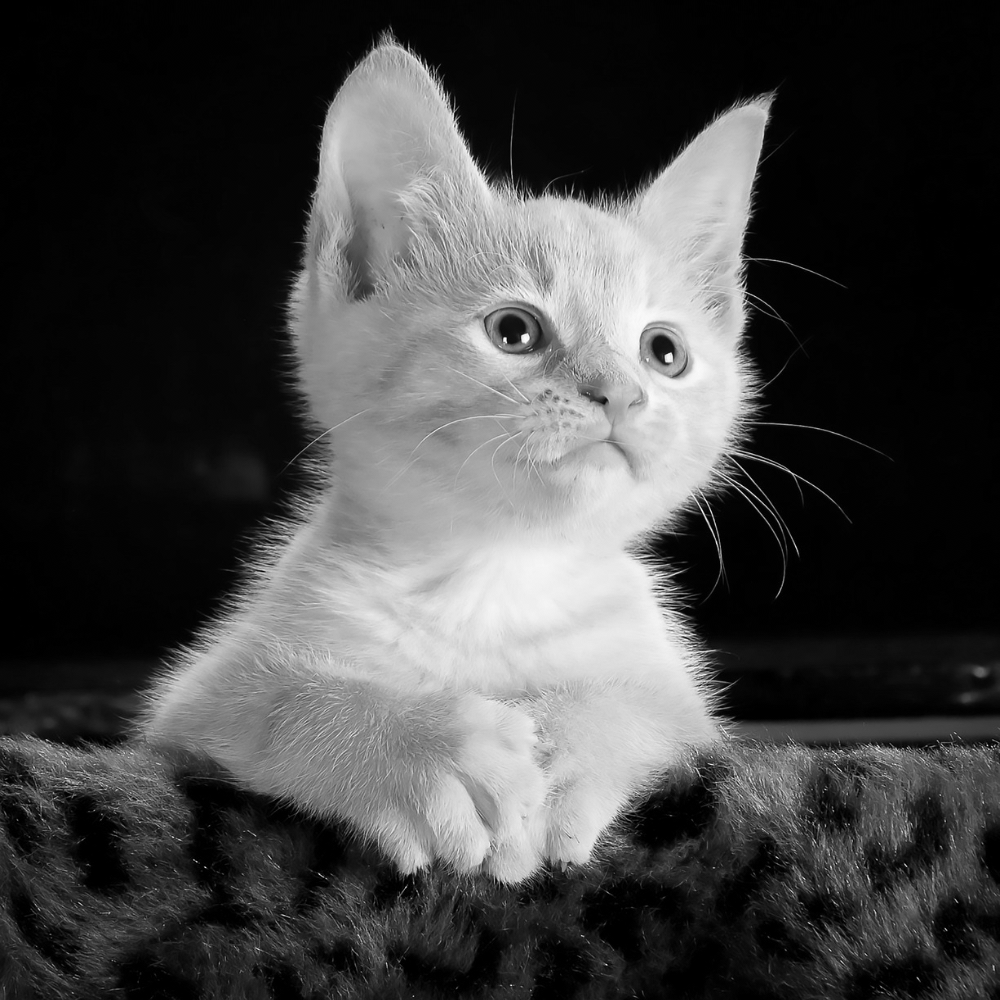

In [ ]:
cv2_imshow(np.array( np.dot(best_U*best_D, best_V_T)))

##The space (percent) was reduced by using SVD (with rank k = r)

In [ ]:
r = 100
old_datatype_size = 1 #unit8
new_datatype_size = 4 #float
A = np.zeros((960,1440)).astype("uint8")
U_k,D_k,V_T_k = np.linalg.svd(A,full_matrices=False)

print(f'r: {r}, full rank: {len(D_k)}')
reduced_space = 100*((old_datatype_size*A.size) - new_datatype_size*(U_k[:,:r].size + D_k[:r].size + V_T_k[:r,:].size))/(old_datatype_size*A.size)
print(f'size_of_image: {A.shape}, type: {A.dtype}')
print(f'size_and_type_of_3_components (rank k = r): {U_k[:,:r].shape}.{U_k[:,:r].dtype} + {best_D[:r].shape}.{best_D[:r].dtype} + {best_V_T[:r,:].shape}.{best_V_T[:r,:].dtype}')
print(f'The space (percent) was reduced by using SVD (with rank k = r): {reduced_space}')

r: 100, full rank: 960
size_of_image: (960, 1440), type: uint8
size_and_type_of_3_components (rank k = r): (960, 100).float64 + (100,).float64 + (100, 1000).float64
The space (percent) was reduced by using SVD (with rank k = r): 30.52662037037037
